In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot

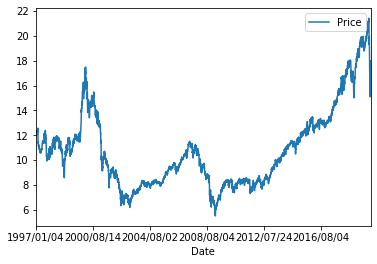

In [2]:
Data = pd.read_csv("Nomura_Global_Equity_Fund.csv")
Data.plot(x='Date', y='Price')

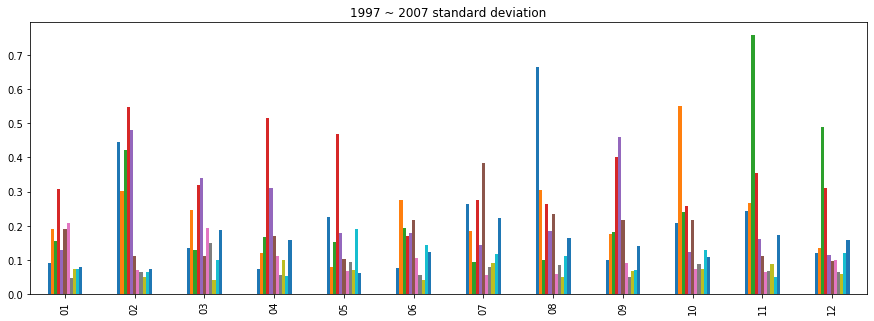

In [5]:
yearStdBarChart(1997, 2007)

In [6]:
tenPercentTenDays = percentDaysStrategy(10,10)

print("fivePercentTenDays avg price : ", avgPriceOfFPTD)

tenPercentTenDays avg price :  9.91132530120482
tenPercentFiveDays avg price :  10.968
fivePercentTenDays avg price :  10.496696035242291


In [32]:
def percentDaysStrategy(percent, days):
    '''Return additional buying point of Percent-Days Strategy'''
    percentDataFrame = pd.DataFrame(columns = ["Date", "Price"])
    index = 0
    
    for i in range(days, Data["Price"].size):
        daysArr = np.array(Data["Price"][i - days: i])
        rateOfDates = Data["Price"][i] / daysArr
        smallThenPercent = np.less_equal(rateOfDates, (100 - percent) / 100)
        
        if (True in smallThenPercent):
            percentDataFrame.loc[index] = [Data["Date"][i], Data["Price"][i]]
            index += 1
    return percentDataFrame

def monthStandardDeviation(year):
    '''Calculate month standard deviation of one year'''
    monthStr = ["/01", "/02", "/03", "/04", "/05", "/06", "/07", "/08", "/09", "/10", "/11", "/12"]
    monthDataFrame = pd.DataFrame(columns = ["Date", "Std"])
    
    for i in range (12):
        monthPrice = []
        
        for j in range (Data["Date"].size):
            if (str(str(year) + monthStr[i]) in Data["Date"][j]):
                monthPrice.append(Data["Price"][j])
            
        monthStd = np.std(np.array(monthPrice))
        monthDataFrame.loc[i] = [str(str(year) + monthStr[i]), monthStd]
    return monthDataFrame

def yearStdBarChart(start, end):
    '''Plot standard deviation bar chart between start year and end year'''
    stdBarDict = {}
    monthStr = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

    for i in range(end - start + 1):
        stdBarDict[str(start + i)] = np.array(monthStandardDeviation(start + i)["Std"])

    yearDataFrame = pd.DataFrame(data = stdBarDict, index = monthStr);
    yearDataFrame.plot.bar(title = str(start) + " ~ " + str(end) + " standard deviation", figsize=(15,5), legend=False);

def investAvgPrice(dataframe):
    '''Return price average of buying point'''
    priceArr = np.array(dataframe["Price"])
    priceAvg = np.sum(priceArr) / np.size(priceArr)
    
    return priceAvg

def percentDaysStrategDataFrame(percent, days):
    '''Return regular buying point and additional buying point'''
    strategyDataFrame = pd.DataFrame(columns = ["Date", "Price"])
    regularDataFrame = pd.DataFrame(columns = ["Date", "Price"])

    for i in range(Data["Price"].size):
        if (re.search("01$", str(Data["Date"][i]))):
            regularDataFrame.loc[i] = [Data["Date"][i], Data["Price"][i]]

    additionalBuyingDataFrame = percentDaysStrategy(10,10)
    strategyDataFrame = pd.concat([regularDataFrame, additionalBuyingDataFrame], axis=0, ignore_index=True)
    strategyDataFrame = strategyDataFrame.sort_values(by=['Date'])
    return strategyDataFrame.reset_index(drop=True)

def investROI(dataFrame):
    '''Return on investment'''
    balances = []
    priceAvg = 0
    for i in range(dataFrame["Price"].size):
        priceAvg = (priceAvg * len(balances) + dataFrame["Price"][i]) / (len(balances) + 1)
        balances.append(priceAvg)
    return balances
        
    

In [33]:
investROI(percentDaysStrategDataFrame(10,10))

[12.43,
 11.86,
 11.659999999999998,
 11.559999999999999,
 11.499999999999998,
 11.446666666666665,
 11.402857142857142,
 11.37125,
 11.338888888888889,
 11.292,
 11.367272727272727,
 11.291666666666666,
 11.227692307692308,
 11.160714285714286,
 11.108,
 11.06,
 11.000588235294119,
 10.94777777777778,
 10.900526315789477,
 10.869000000000003,
 10.863809523809525,
 10.898636363636365,
 10.934347826086958,
 10.936666666666667,
 10.883200000000002,
 10.833846153846157,
 10.786666666666669,
 10.74714285714286,
 10.705517241379313,
 10.669000000000004,
 10.60903225806452,
 10.554062500000004,
 10.498787878787883,
 10.442352941176475,
 10.395428571428576,
 10.411388888888894,
 10.448648648648653,
 10.4471052631579,
 10.445641025641029,
 10.442500000000003,
 10.439024390243905,
 10.435952380952383,
 10.438837209302328,
 10.461590909090912,
 10.486888888888892,
 10.514130434782611,
 10.555106382978726,
 10.635208333333336,
 10.735510204081635,
 10.8664,
 10.96137254901961,
 11.016730769230772

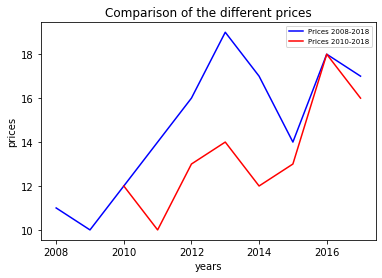

In [21]:
from matplotlib import pyplot as plt

Geb_b30 = [11, 10, 12, 14, 16, 19, 17, 14, 18, 17]
years_b30 = range(2008,2018)
Geb_a30 = [12, 10, 13, 14, 12, 13, 18, 16]
years_a30 = range(2010,2018)

fig, ax = plt.subplots()
ax.plot(years_b30, Geb_b30, label='Prices 2008-2018', color='blue')
ax.plot(years_a30, Geb_a30, label='Prices 2010-2018', color = 'red')
legend = ax.legend(loc='best', fontsize='x-small')
plt.xlabel('years')
plt.ylabel('prices')
plt.title('Comparison of the different prices')
plt.show()